In [20]:
import requests
import numpy as np
import pandas as pd
import yaml
import datetime 
import base64
import json
import pytz
import matplotlib.pyplot as plt

## Set up MIDAS conifg.yaml and credentials

In [21]:
with open("midas_config.yaml") as fp:
    config = yaml.safe_load(fp)
midas_config = config.get("midas", {})
midas_username = midas_config.get("username")
midas_password = midas_config.get("password")

In [22]:
def GetSchema(token):
    headers = {'accept': 'application/json', 'Authorization': "Bearer " + token}
    url = 'https://midasapi.energy.ca.gov/api/valuedata'
    pricing_response = requests.get(url, headers=headers)

    return (json.loads(pricing_response.text))

In [23]:
#Function passes through your MIDAS username and password as strings and returns the JWT token as a string
def GetToken(username, password):
    credentials = username + ":" + password
    credentials_encodedBytes = base64.b64encode(credentials.encode("utf-8"))
   
    headers = {b'Authorization': b'BASIC ' + credentials_encodedBytes}
    url = 'https://midasapi.energy.ca.gov/api/token'

    response = requests.get(url,headers=headers)
    print(response.text)

    return response.headers['Token']

In [24]:
def GetRINList(token, signaltype):
    headers = {'accept': 'application/json', 'Authorization': "Bearer " + token}
    url = 'https://midasapi.energy.ca.gov/api/valuedata?signaltype=' + signaltype
    list_response = requests.get(url, headers=headers)
    return (json.loads(list_response.text))

In [25]:
#Query passes in JWT access token as "token", Rate Identification Number (RIN) as rateID formatted as a string, and "alldata" or "realtime" for queryType formatted as a string
def GetValue(token, rateID, queryType):
    headers = {'accept': 'application/json', 'Authorization': "Bearer " + token}
    url = 'https://midasapi.energy.ca.gov/api/valuedata?id=' + rateID + '&querytype=' + queryType
    pricing_response = requests.get(url, headers=headers)

    return (json.loads(pricing_response.text))

# Get MIDAS Server Rate Function

In [32]:
url_base = 'https://api.olivineinc.com/i/lbnl/v1/prices/cfh/'
cfh_midas_rin_dict = {'SummerHDP':'USCA-CFCF-SHDP-0000',
                    'SummerGHG': 'USCA-CFCF-SUDG-0000',
                    'SpringHDP': 'USCA-CFCF-SPDP-0000', 
                    'SpringGHG': 'USCA-CFCF-SPDG-0000', 
                    'WinterHDP': 'USCA-CFCF-WIDP-0000', 
                    'WinterGHG': 'USCA-CFCF-WIDG-0000', 
                    'FallHDP': 'USCA-CFCF-FLDP-0000', 
                    'FallGHG': 'USCA-CFCF-FLDG-0000',
}

In [33]:
def get_rate(rin_name, rin_dict):
    Token=GetToken(midas_username, midas_password)
    op = GetValue(Token, rin_dict[rin_name], "alldata")
    st_list = []
    et_list = []
    price_list = []
    for value_dict in op['ValueInformation']:
        st = pytz.timezone("UTC").localize(datetime.datetime.strptime("{} {}".format(value_dict["DateStart"], value_dict['TimeStart']), "%Y-%m-%d %H:%M:%S")).astimezone(pytz.timezone("US/Pacific"))
        et = pytz.timezone("UTC").localize(datetime.datetime.strptime("{} {}".format(value_dict["DateEnd"], value_dict['TimeEnd']), "%Y-%m-%d %H:%M:%S")).astimezone(pytz.timezone("US/Pacific"))
        price = value_dict['value']
        st_list.append(st)
        et_list.append(et)
        price_list.append(price)

    df = pd.DataFrame(index=range(0,len(st_list)), data={'start_time': st_list, 'end_time': et_list, 'price': price_list}).set_index('start_time').sort_index()
    return df

In [34]:
def plot_rate(df, rin_name):
    plt.rcParams["figure.figsize"] = (11,5)
    fig = plt.figure()
    idx = [x.strftime('%H') for x in df.index]
    plt.step(idx, df.price, where = 'post', label = rin_name)
    plt.ylabel('$/kWh')
    plt.xlabel('Hour of Day')
    plt.grid(alpha = 0.4)
    plt.xticks(idx)
    #plt.title('TOU HDP Price Signals')
    plt.legend()
    plt.ylim(0,0.9)
    plt.show()

Token issued and will expire in 10 minutes.
SummerHDP
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.356
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.489
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.710
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.788
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.559
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.333
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.215
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.149
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.086
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.059
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.038
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.025
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.016
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.022
20

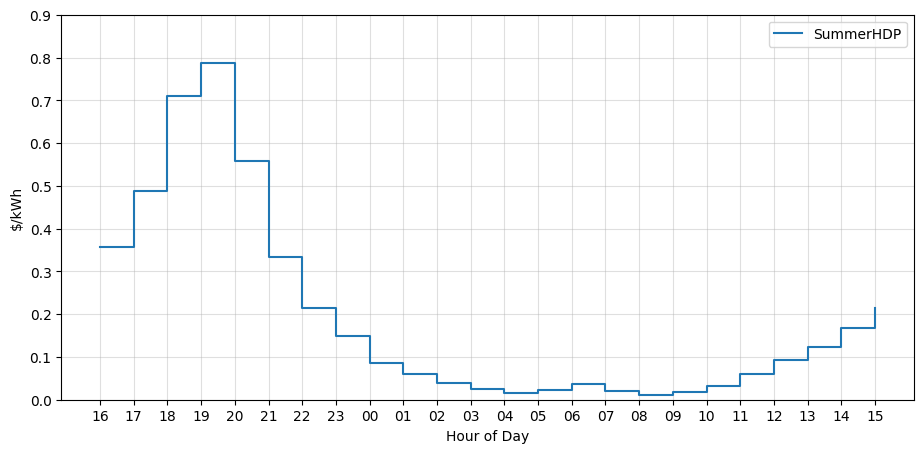

Token issued and will expire in 10 minutes.
SummerGHG
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.431
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.433
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.444
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.443
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.436
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.432
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.427
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.423
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.420
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.422
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.421
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.422
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.428
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.429
20

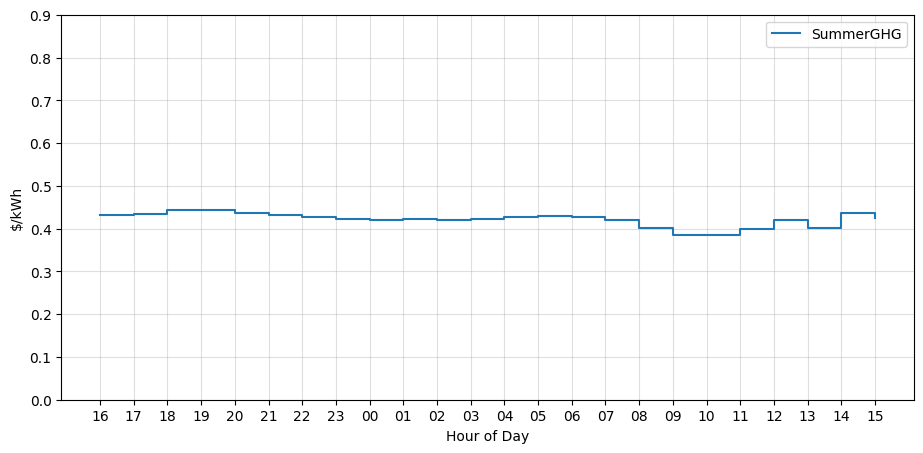

Token issued and will expire in 10 minutes.
SpringHDP
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.096
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.236
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.493
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.662
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.536
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.412
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.290
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.221
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.171
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.144
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.138
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.152
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.183
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.271
20

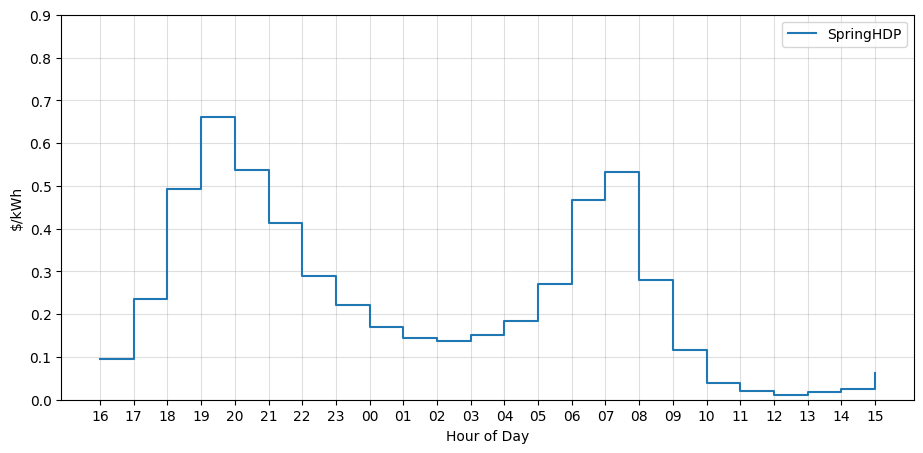

Token issued and will expire in 10 minutes.
SpringGHG
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.215
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.431
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.424
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.424
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.421
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.417
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.412
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.409
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.400
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.402
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.413
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.416
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.417
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.404
20

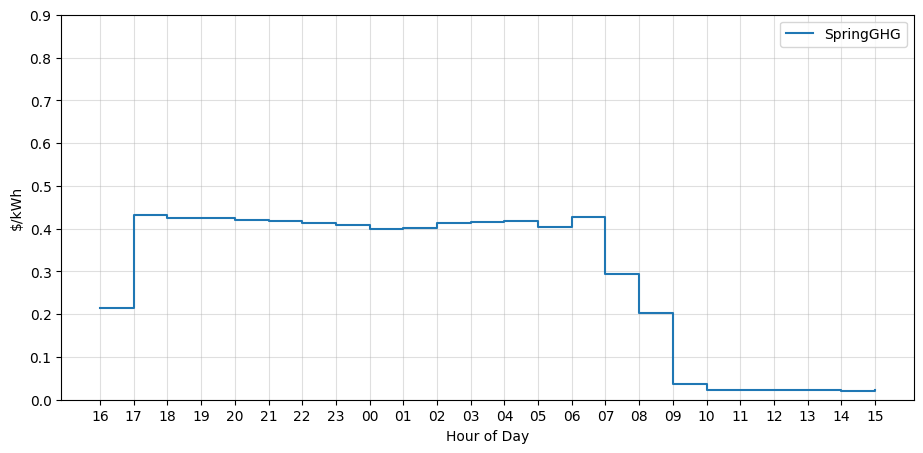

Token issued and will expire in 10 minutes.
WinterHDP
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.396
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.525
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.497
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.452
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.392
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.311
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.200
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.111
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.072
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.044
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.020
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.011
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.033
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.110
20

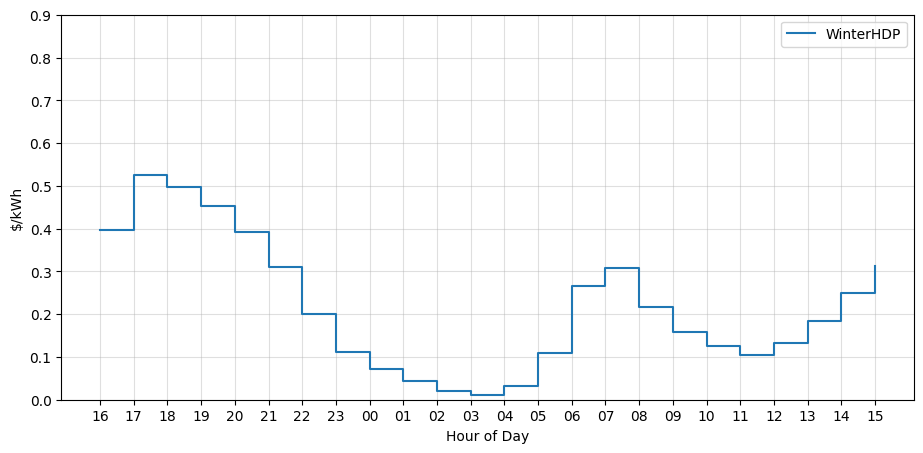

Token issued and will expire in 10 minutes.
WinterGHG
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.438
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.441
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.440
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.430
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.412
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.415
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.408
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.421
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.403
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.408
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.405
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.407
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.401
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.408
20

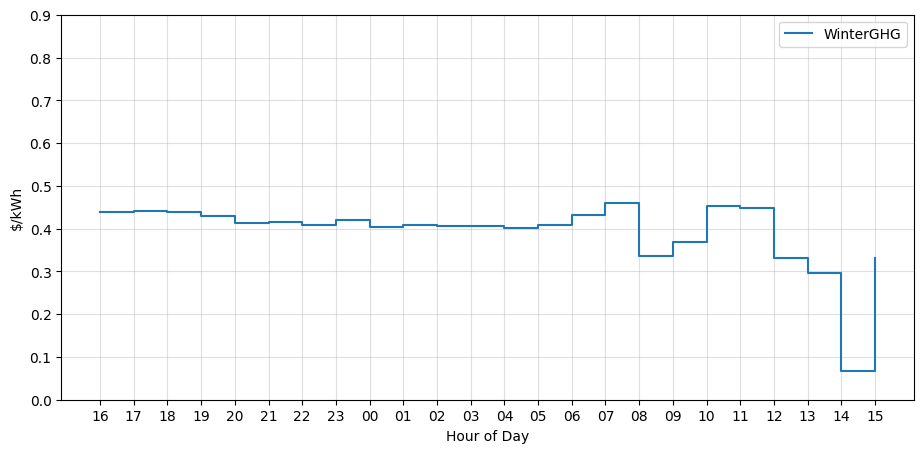

Token issued and will expire in 10 minutes.
FallHDP
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.305
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.520
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.725
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.694
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.496
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.357
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.182
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.041
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.205
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.128
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.079
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.053
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.055
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.119
2023

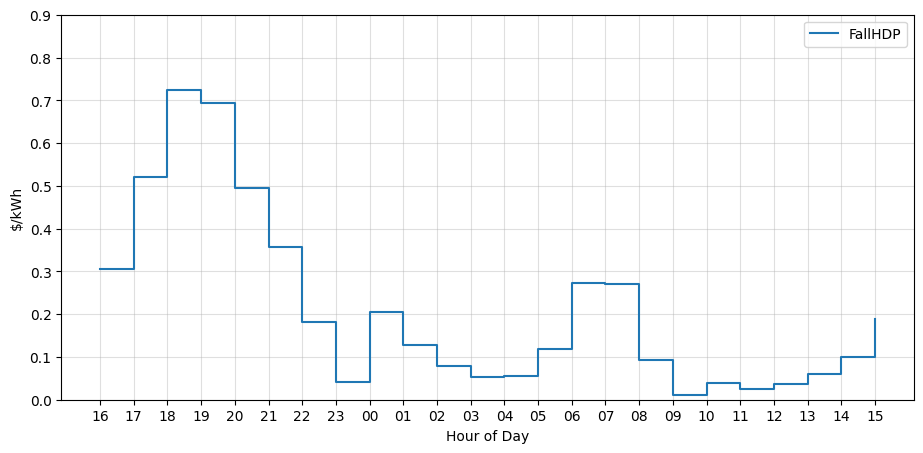

Token issued and will expire in 10 minutes.
FallGHG
                                           end_time  price
start_time                                                
2023-06-08 16:00:00-07:00 2023-06-08 16:59:59-07:00  0.432
2023-06-08 17:00:00-07:00 2023-06-08 17:59:59-07:00  0.438
2023-06-08 18:00:00-07:00 2023-06-08 18:59:59-07:00  0.438
2023-06-08 19:00:00-07:00 2023-06-08 19:59:59-07:00  0.436
2023-06-08 20:00:00-07:00 2023-06-08 20:59:59-07:00  0.424
2023-06-08 21:00:00-07:00 2023-06-08 21:59:59-07:00  0.423
2023-06-08 22:00:00-07:00 2023-06-08 22:59:59-07:00  0.422
2023-06-08 23:00:00-07:00 2023-06-08 23:59:59-07:00  0.422
2023-06-09 00:00:00-07:00 2023-06-09 00:59:59-07:00  0.420
2023-06-09 01:00:00-07:00 2023-06-09 01:59:59-07:00  0.423
2023-06-09 02:00:00-07:00 2023-06-09 02:59:59-07:00  0.425
2023-06-09 03:00:00-07:00 2023-06-09 03:59:59-07:00  0.430
2023-06-09 04:00:00-07:00 2023-06-09 04:59:59-07:00  0.436
2023-06-09 05:00:00-07:00 2023-06-09 05:59:59-07:00  0.438
2023

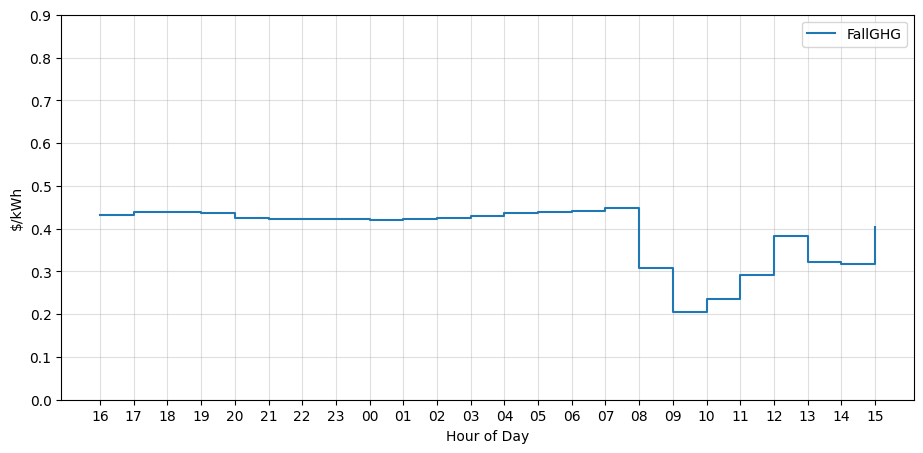

In [35]:
for rin_name, url in cfh_midas_rin_dict.items():
    df = get_rate(rin_name, cfh_midas_rin_dict)
    print(rin_name)
    print(df)
    plot_rate(df, rin_name)